# Statistical foundation of machine learning

In [1]:
import numpy as np
from prep import TimeWindowTransformer, LabelWindowExtractor, TimeDomainTransformer

# adjust import if needed

## Loading raw data

In [2]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

In [3]:
# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)


X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

In [4]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

**Disclaimer:** EVERY model/pipeline we create MUST take in input a numpy array of shape (N, 8, 500) and return a numpy array of shape (N, 51). The usage is:

model.fit(X, y)  --> Here X is of shape (N, 8, 500), y is of shape (N, 51) ; we are not supposed to use the return of this method, the method changes the model in place.

model.predict(X) --> Here X is of shape (N, 8, 500), and the return is of shape (N, 51)

The transformers have a fit_transform() method, which is the only one used. They take (N, 8, 500) and return something else of shape (N,...) depending on which transformer is used.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from validation import *
import matplotlib.pyplot as plt

import pyriemann
import pyriemann.regression

### Time domain pipelines

In [6]:
time_est0 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer(0.3)),
        ('regressor', Lasso())
    ]
)

time_est1 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('kernel_ridge', KernelRidge())
    ]
)

time_est2 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('multioutput_svr', MultiOutputRegressor(SVR()))
    ]
)

time_est3 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('decision_tree', DecisionTreeRegressor())
    ]
)

time_est4 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('extra_tree', ExtraTreeRegressor())
    ]
)

time_est5 = Pipeline(
    [
        ('time_domain_features', TimeDomainTransformer()),
        ('random_forest', RandomForestRegressor(
            n_estimators = 30
        ))
    ]
)

In [10]:
# Evaluation example
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
pipeline = time_est1

result = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)


Fold 1
RMSE: train=5.4188, val=7.7640
NMSE: train=0.1448, val=0.3110

Fold 2
RMSE: train=5.4256, val=6.8122
NMSE: train=0.1456, val=0.2358

Fold 3
RMSE: train=5.3962, val=7.0602
NMSE: train=0.1480, val=0.2342

Fold 4
RMSE: train=5.6420, val=6.5362
NMSE: train=0.1575, val=0.2165

Mean Validation Scores:
RMSE: train=5.4706, val=7.0432
NMSE: train=0.1490, val=0.2494


In [ ]:
# Parameter selection
param_grid = {
    'kernel_ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}

sweep_results = parameter_selection(pipeline, param_grid, X_train_val_folds, Y_train_val_folds, metric_fns)


Testing parameters: {'kernel_ridge__alpha': 0.001}


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.46513e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 1
RMSE: train=6.2168, val=8.6005
NMSE: train=0.1906, val=0.3816


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.62484e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 2
RMSE: train=6.1098, val=7.3299
NMSE: train=0.1847, val=0.2730


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.26074e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 3
RMSE: train=6.1235, val=7.8401
NMSE: train=0.1906, val=0.2888


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.61676e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 4
RMSE: train=6.6880, val=7.4466
NMSE: train=0.2214, val=0.2810

Mean Validation Scores:
RMSE: train=6.2845, val=7.8043
NMSE: train=0.1968, val=0.3061

Testing parameters: {'kernel_ridge__alpha': 0.01}


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.47701e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 1
RMSE: train=5.3880, val=7.8424
NMSE: train=0.1431, val=0.3173


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.63813e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 2
RMSE: train=5.3901, val=6.8057
NMSE: train=0.1438, val=0.2354


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.51272e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 3
RMSE: train=5.3648, val=7.0648
NMSE: train=0.1463, val=0.2345


c:\Users\gianm\miniforge3\envs\test\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.62962e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



Fold 4
RMSE: train=5.5935, val=6.5801
NMSE: train=0.1548, val=0.2194

Mean Validation Scores:
RMSE: train=5.4341, val=7.0732
NMSE: train=0.1470, val=0.2516

Testing parameters: {'kernel_ridge__alpha': 0.1}

Fold 1
RMSE: train=5.3810, val=7.8220
NMSE: train=0.1428, val=0.3156

Fold 2
RMSE: train=5.3867, val=6.8087
NMSE: train=0.1436, val=0.2356

Fold 3
RMSE: train=5.3632, val=7.0523
NMSE: train=0.1462, val=0.2337

Fold 4
RMSE: train=5.5911, val=6.5312
NMSE: train=0.1547, val=0.2161

Mean Validation Scores:
RMSE: train=5.4305, val=7.0536
NMSE: train=0.1468, val=0.2502

Testing parameters: {'kernel_ridge__alpha': 1.0}

Fold 1
RMSE: train=5.4188, val=7.7640
NMSE: train=0.1448, val=0.3110

Fold 2
RMSE: train=5.4256, val=6.8122
NMSE: train=0.1456, val=0.2358

Fold 3
RMSE: train=5.3962, val=7.0602
NMSE: train=0.1480, val=0.2342

Fold 4
RMSE: train=5.6420, val=6.5362
NMSE: train=0.1575, val=0.2165

Mean Validation Scores:
RMSE: train=5.4706, val=7.0432
NMSE: train=0.1490, val=0.2494

Testing 

In [12]:
best = min(sweep_results, key=lambda d: d['mean_val_RMSE'])

print("\nBest Configuration:")
print(best['params'])
print(f"Val RMSE: {best['mean_val_RMSE']:.4f}, Val NMSE: {best['mean_val_NMSE']:.4f}")


Best Configuration:
{'kernel_ridge__alpha': 1.0}
Val RMSE: 7.0432, Val NMSE: 0.2494


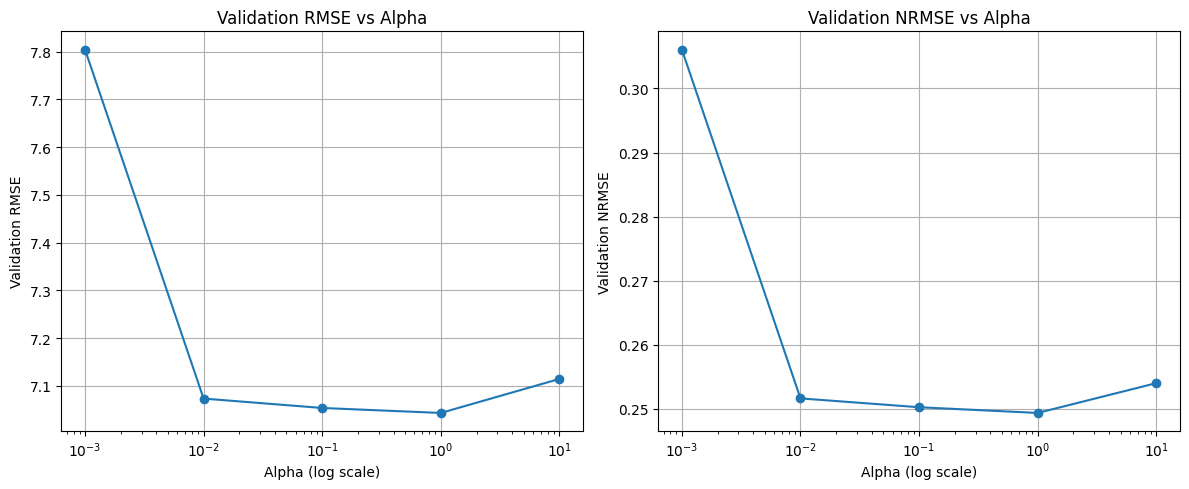

In [ ]:
# Optional

# Extract the alpha values and metrics
alphas = [res['params']['kernel_ridge__alpha'] for res in sweep_results]
rmse_vals = [res['mean_val_RMSE'] for res in sweep_results]
nrmse_vals = [res['mean_val_NMSE'] for res in sweep_results]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(alphas, rmse_vals, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs Alpha')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogx(alphas, nrmse_vals, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Validation NRMSE')
plt.title('Validation NRMSE vs Alpha')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Feature selection

# Flatten and extract time domain features
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
y_flat = Y_train_val_folds.reshape(-1, 51)[:, 0]  # predict first joint for now

# Apply time-domain transformer manually for feature selection
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(X_flat.shape[0], -1)
X_df = pd.DataFrame(X_feat)
y_series = pd.Series(y_flat)
n = X_df.shape[1]
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Mutual information approximation via correlation
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0, 1]
    if abs(c) == 1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi = mutual_info_corr(X_tr[col].values, Y_tr)
        mis.append(mi)
    return np.array(mis)

# Correlation Ranking - ignores redundancy between features 
correlations = np.abs(X_df.corrwith(y_series))
ranking_corr_idx = correlations.sort_values(ascending=False).index.tolist()
CV_err_corr = np.zeros((n, 4))

for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_features in range(1, n + 1):
        selected_features = ranking_corr_idx[:nb_features]
        model = KernelRidge()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err_corr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nCorrelation Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_corr[i,:].mean():.4f}; std dev = {CV_err_corr[i,:].std():.4f}")


--- Correlation Ranking ---
#Features: 1; CV error = 0.6248; std dev = 0.0405
#Features: 2; CV error = 0.6226; std dev = 0.0376
#Features: 3; CV error = 0.6250; std dev = 0.0360
#Features: 4; CV error = 0.6159; std dev = 0.0405
#Features: 5; CV error = 0.5968; std dev = 0.0373
#Features: 6; CV error = 0.5970; std dev = 0.0375
#Features: 7; CV error = 0.5959; std dev = 0.0366
#Features: 8; CV error = 0.5962; std dev = 0.0365
#Features: 9; CV error = 0.5965; std dev = 0.0357
#Features: 10; CV error = 0.5866; std dev = 0.0358
#Features: 11; CV error = 0.5810; std dev = 0.0356
#Features: 12; CV error = 0.5726; std dev = 0.0375
#Features: 13; CV error = 0.5737; std dev = 0.0365
#Features: 14; CV error = 0.5655; std dev = 0.0332
#Features: 15; CV error = 0.5672; std dev = 0.0326
#Features: 16; CV error = 0.5643; std dev = 0.0333
#Features: 17; CV error = 0.5603; std dev = 0.0328
#Features: 18; CV error = 0.5605; std dev = 0.0333
#Features: 19; CV error = 0.5608; std dev = 0.0336
#Features: 

In [ ]:
# mRMR Ranking - requires mutual information computation
CV_err_mrmr = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))

    for j in range(n):
        redundancy_score = np.zeros(len(candidates))
        if len(selected) > 0:
            for cidx in candidates:
                col_c = X_tr.iloc[:, cidx]
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx]
                    cc = np.corrcoef(col_s, col_c)[0, 1]
                    if abs(cc) == 1:
                        cc = 0.999999
                    mis_c.append(-0.5 * np.log(1 - cc**2))
                redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)

    for nb_features in range(1, n + 1):
        features_to_use = [X_df.columns[i] for i in selected[:nb_features]]
        model = KernelRidge()
        model.fit(X_tr[features_to_use], Y_tr)
        Y_hat_ts = model.predict(X_ts[features_to_use])
        CV_err_mrmr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nmRMR Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")


mRMR Ranking
#Features: 1; CV error = 0.6248; std dev = 0.0405
#Features: 2; CV error = 0.5944; std dev = 0.0484
#Features: 3; CV error = 0.5493; std dev = 0.0786
#Features: 4; CV error = 0.5011; std dev = 0.0310
#Features: 5; CV error = 0.4956; std dev = 0.0263
#Features: 6; CV error = 0.4965; std dev = 0.0253
#Features: 7; CV error = 0.4894; std dev = 0.0265
#Features: 8; CV error = 0.4881; std dev = 0.0271
#Features: 9; CV error = 0.4830; std dev = 0.0225
#Features: 10; CV error = 0.4799; std dev = 0.0212
#Features: 11; CV error = 0.4685; std dev = 0.0236
#Features: 12; CV error = 0.4393; std dev = 0.0556
#Features: 13; CV error = 0.4003; std dev = 0.0668
#Features: 14; CV error = 0.3338; std dev = 0.0165
#Features: 15; CV error = 0.3319; std dev = 0.0140
#Features: 16; CV error = 0.3285; std dev = 0.0115
#Features: 17; CV error = 0.3278; std dev = 0.0110
#Features: 18; CV error = 0.3258; std dev = 0.0123
#Features: 19; CV error = 0.3239; std dev = 0.0118
#Features: 20; CV error = 

In [ ]:
# PCA - produces unstructured components (not original features)
pca = PCA()
X_pca = pca.fit_transform(X_df)
CV_err_pca = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_pca)):
    X_tr, X_ts = X_pca[train_index], X_pca[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_components in range(1, n + 1):
        model = KernelRidge()
        model.fit(X_tr[:, :nb_components], Y_tr)
        Y_hat_ts = model.predict(X_ts[:, :nb_components])
        CV_err_pca[nb_components - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nPCA Components")
for i in range(n):
    print(f"#Components: {i+1}; CV error = {CV_err_pca[i,:].mean():.4f}; std dev = {CV_err_pca[i,:].std():.4f}")


PCA Components
#Components: 1; CV error = 98.6223; std dev = 4.5121
#Components: 2; CV error = 98.5056; std dev = 4.7518
#Components: 3; CV error = 98.5397; std dev = 4.7656
#Components: 4; CV error = 98.4401; std dev = 4.6198
#Components: 5; CV error = 98.4977; std dev = 4.6015
#Components: 6; CV error = 98.5252; std dev = 4.7241
#Components: 7; CV error = 98.5215; std dev = 4.7334
#Components: 8; CV error = 98.6023; std dev = 4.8175
#Components: 9; CV error = 98.5845; std dev = 4.7697
#Components: 10; CV error = 98.7288; std dev = 4.7410
#Components: 11; CV error = 98.8400; std dev = 4.6875
#Components: 12; CV error = 98.8654; std dev = 4.6962
#Components: 13; CV error = 98.9467; std dev = 4.5882
#Components: 14; CV error = 99.0918; std dev = 4.5736
#Components: 15; CV error = 99.1201; std dev = 4.6316
#Components: 16; CV error = 99.1056; std dev = 4.6424
#Components: 17; CV error = 99.2392; std dev = 4.7640
#Components: 18; CV error = 99.2551; std dev = 4.7401
#Components: 19; CV e

In [20]:
# estimation example
X_train_example = np.random.random((1000, 8, 500))
Y_train_example = np.random.random((1000, 51))

X_test_example = np.random.random((100, 8, 500))

pipeline.fit(X_train_example, Y_train_example)
Y_pred_example = pipeline.predict(X_test_example)

print(Y_pred_example.shape)

(100, 51)


### Riemannian geometry pipelines

In [21]:
# # ----- Riemannian geometry of covariance matrices ----- #
geom_est0 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('svr', MultiOutputRegressor(pyriemann.regression.SVR()))
    ]
)

geom_est1 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('kernel_ridge', KernelRidge(
            kernel='laplacian'))
    ]
)

geom_est2 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

geom_est3 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', Lasso())
    ]
)

geom_est4 = Pipeline(
    [
        ('cov_matrices', pyriemann.estimation.Covariances()),
        ('projection', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', MultiOutputRegressor(GradientBoostingRegressor()))
    ]
)

In [22]:
print('Kernels for ridge:')
display({'additive_chi2', 'polynomial', 'laplacian', 'poly', 'sigmoid', 'precomputed', 'cosine', 'rbf', 'linear', 'chi2'})
print('Kernels for SVR:')
display({'linear', 'poly', 'rbf', 'sigmoid'})

Kernels for ridge:


{'additive_chi2',
 'chi2',
 'cosine',
 'laplacian',
 'linear',
 'poly',
 'polynomial',
 'precomputed',
 'rbf',
 'sigmoid'}

Kernels for SVR:


{'linear', 'poly', 'rbf', 'sigmoid'}

### Ensemble regressors

In [23]:
from ensemble import VotingRegressor

ens_est0 = VotingRegressor(
    estimators = [time_est5, geom_est1, geom_est4]
)

### Estimator validation

In [24]:
pipeline = geom_est1 # change this to validate another pipeline

results = {}
for fold in range(4):
    train_idx = [0,1,2,3]
    train_idx.remove(fold)
    val_idx = fold

    X_train = X_train_val_folds[train_idx].reshape(-1, *X_train_val_folds.shape[2:])
    Y_train = Y_train_val_folds[train_idx].reshape(-1, *Y_train_val_folds.shape[2:])
    X_val = X_train_val_folds[val_idx]
    Y_val = Y_train_val_folds[val_idx]
    
    pipeline.fit(X_train, Y_train)
    Y_train_pred = pipeline.predict(X_train)
    Y_val_pred = pipeline.predict(X_val)
    print(f"Fold {fold+1}\n.\
          train RMSE:\t{RMSE(Y_train_pred, Y_train):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train):.4f}\n.\
            val RMSE:\t{RMSE(Y_val_pred, Y_val):.4f}\tval NMSE:\t{NMSE(Y_val_pred, Y_val):.4f}")
    
    results[fold] = {
        'train_RMSE': RMSE(Y_train_pred, Y_train),
        'train_NMSE': NMSE(Y_train_pred, Y_train),
        'val_RMSE': RMSE(Y_val_pred, Y_val),
        'val_NMSE': NMSE(Y_val_pred, Y_val),
    }

mean_val_RMSE = np.mean([dic['val_RMSE'] for dic in results.values()])
mean_val_NMSE = np.mean([dic['val_NMSE'] for dic in results.values()])
print('Mean val RMSE:', mean_val_RMSE)
print('Mean val NMSE:', mean_val_NMSE)

Fold 1
.          train RMSE:	4.1784	train NMSE:	0.0861
.            val RMSE:	5.2349	val NMSE:	0.1414
Fold 2
.          train RMSE:	4.0782	train NMSE:	0.0823
.            val RMSE:	5.6354	val NMSE:	0.1614
Fold 3
.          train RMSE:	3.9478	train NMSE:	0.0792
.            val RMSE:	6.7454	val NMSE:	0.2138
Fold 4
.          train RMSE:	4.3051	train NMSE:	0.0917
.            val RMSE:	4.8671	val NMSE:	0.1200
Mean val RMSE: 5.620692956194527
Mean val NMSE: 0.15913117968559676


### Visualizing predictions to unseen data

In [25]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

pipeline.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = pipeline.predict(X_train_val_flat)
Y_test_pred = pipeline.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}\ntest RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

train RMSE:	4.1085	train NMSE:	0.0840
test RMSE:	5.6236	test NMSE:	0.1504


RMSE for bone 6: 6.795998376776287
NMSE for bone 6: 0.22385328672372834


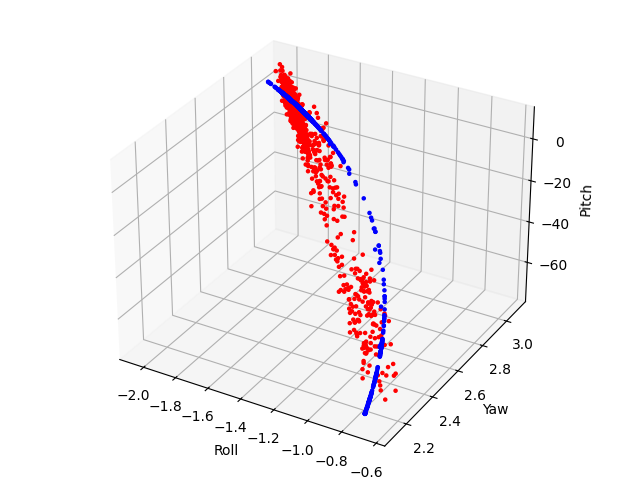

In [26]:
from visualization_tools import scatter_3d_points
import matplotlib.pyplot as plt
%matplotlib ipympl

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()